<a href="https://colab.research.google.com/github/robomoan/Data_Science_Study/blob/main/Handson_ML/handson_ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# 3. 분류

## MNIST 생성

In [25]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

 * DESCR: 데이터셋을 설명하는 키
 * data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 키
 * target: 레이블 배열을 담은 키

In [26]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


첫번째 샘플 재구조화

In [27]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

print(some_digit_image.shape)

(28, 28)


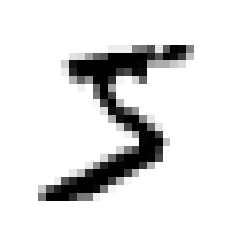

In [28]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [29]:
y[0]

'5'

In [30]:
# 문자형을 숫자형으로 변환
y = y.astype(np.uint8)

데이터셋을 훈련데이터와 검증 데이터로 나누기

In [31]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

5가 맞는지 아닌지 감지하는 5 감지기 훈련, 확률적 경사 하강법 이용

In [32]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [33]:
# 확률적 경사하강법 클래스 부르기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 72)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=72)

In [34]:
# 분류기를 가지고 데이터 샘플 분류하기 (실제 5)
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차검증을 통한 정확도 측정

`cross_val_score` 함수와 같은 식

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=72, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95685
0.94185
0.96055


In [36]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9377, 0.9689, 0.9596])

In [37]:
# 모든 이미지가 5가 아니라고 분류하는 더미 분류기 생성
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [38]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

전체 데이터 중 10%가 5이기 때문에 90%의 정확도를 보이는 것은 당연  
불균형한 데이터셋을 다룰 때 정확도를 사용하지 않는 이유

### 오차 행렬

`cross_val_predict()`함수는 k-fold 교차검증을 수행하지만 평가점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [39]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52882,  1697],
       [  979,  4442]])

1행: 실제로 5가 아님(0), 2행: 실제로 5임(1)  
1열: 5가 아니라고 예측함(0), 2열: 5라고 예측함(1)

* True Negative(5 아닌것을 정확히 예측): 52882
* True Positive(5 인것을 정확히 예측): 4442
* False Positive(5 아닌것을 잘못 예측): 1697
* False Negative(5 인것을 잘못 예측: 979

정밀도(precision): $\frac{TP}{TP + FP}$  
재현율(recall): $\frac{TP}{TP + FN}$

In [42]:
from sklearn.metrics import precision_score, recall_score

# 정확도(precision)
print(precision_score(y_train_5, y_train_pred)) # 4442 / (4442 + 1697)

# 재현율(recall)
print(recall_score(y_train_5, y_train_pred)) # 4442 / (4442 + 979)

0.723570614106532
0.8194060136506179


$F_1$-score: 정밀도와 재현율의 조화평균  
$F_{1} = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}}$ 

In [43]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7685121107266436

In [44]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2724.62726715])

임곗값 조정

In [46]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [47]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [49]:
# 적절한 임곗값 정하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  7874.26525882,  -6852.2847618 , -22648.42958088, ...,
        13683.76978851,  -5562.46911999, -10352.3441059 ])

In [51]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

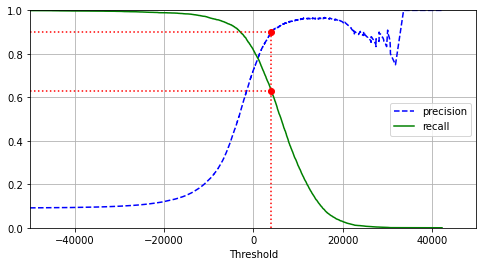

In [64]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
  plt.legend(loc="center right")
  plt.xlabel("Threshold")
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") # 빨간색 세로줄
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") # 빨간색 위 가로줄
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # 빨간색 아래 가로줄
plt.plot([threshold_90_precision], [0.9], "ro") # 빨간색 위 점
plt.plot([threshold_90_precision], [recall_90_precision], "ro") # 빨간색 아래 점
plt.show()

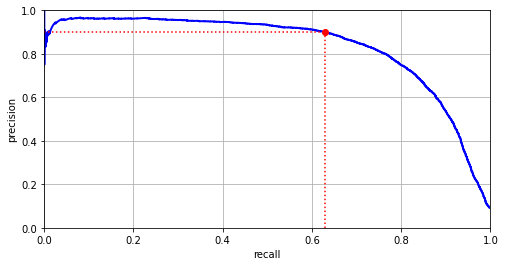

In [58]:
def precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, "b-", linewidth=2)
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.grid(True)
  plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 4))
precision_vs_recall(precisions, recalls)
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [66]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9
0.6292197011621472


### ROC 곡선

ROC: FPR에 대한 TPR의 그래프  
FPR: 실제 음성들 분모, 음성이지만 양성으로 예측 분자  
TPR: 실제 양성들 분모, 양성으로 맞게 예측 분자(재현율과 같다.)

TNR(특이도): 실제 음성들 분모, 음성을 음성으로 맞게 예측 분자  
FPR = 1- TNR

ROC: 민감도(재현율)에 대한 1-특이도 그래프


In [67]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

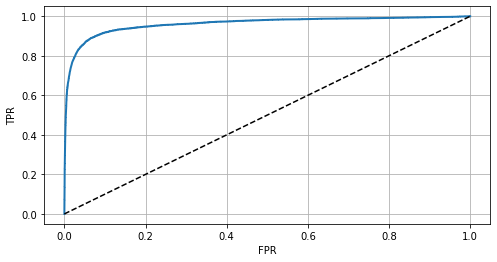

In [70]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0 ,1], [0, 1], "k--")
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.grid(True)

plt.figure(figsize=(8, 4))
plot_roc_curve(fpr, tpr)
plt.show()

AUC: ROC 곡선 아래의 면적  
완벽한 분류기: AUC=1, 완전한 랜덤 분류기: AUC=0.5

In [71]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9607487588946978

랜덤 포레스트 방식과 SGD 방식 비교

`predict_proba` 매서드: 샘플당 각 클래스에 속할 확률을 출력

In [74]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=72)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [75]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

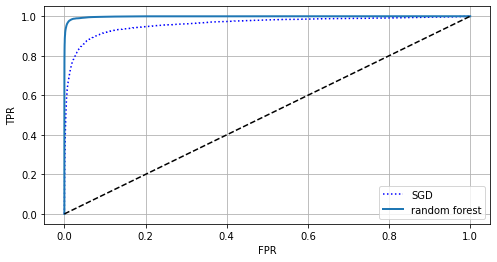

In [77]:
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.show()

In [78]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983474179858511